# Phase 2: Optimal EVBSS Placement using CLIMFO

This notebook serves as the main analysis hub. It integrates the core `CLIMFO` optimizer and `CostCalculator` modules to find and visualize the optimal locations for Electric Vehicle Battery Swapping Stations (EVBSS).

**Objective:** Run the optimization for a fixed number of stations (`D=5`) and display the results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import sys
import os

# Add the src directory to the Python path to import our custom modules
# This allows the notebook to find climfo_optimizer.py and cost_function.py
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.climfo_optimizer import CLIMFO
from src.cost_function import CostCalculator

print("Modules imported successfully!")

Modules imported successfully!


## Section 2: Data Loading & Preprocessing

First, we load the geospatial data for our problem:
* **Candidate Locations:** A list of all potential sites where an EVBSS can be built.
* **Demand Points:** The centroids of demand, including the annual number of swaps required.

In [2]:
# Load the datasets
try:
    candidate_locations_df = pd.read_csv('../data/candidate_locations.csv')
    demand_points_df = pd.read_csv('../data/demand_points.csv')

    # Convert to NumPy arrays for efficient processing
    candidate_locations = candidate_locations_df[['x', 'y']].values
    demand_points = demand_points_df[['x', 'y', 'demand']].values

    print(f"Loaded {len(candidate_locations)} candidate locations.")
    print(f"Loaded {len(demand_points)} demand points.")

except FileNotFoundError as e:
    print(f"Error: {e}. Make sure the data files are in the 'data/' directory.")

Loaded 33 candidate locations.
Loaded 21 demand points.


### Visualize the Problem Space

Let's create a plot to visualize the distribution of candidate sites and demand points. This gives us a good intuition for the problem we're asking the optimizer to solve.

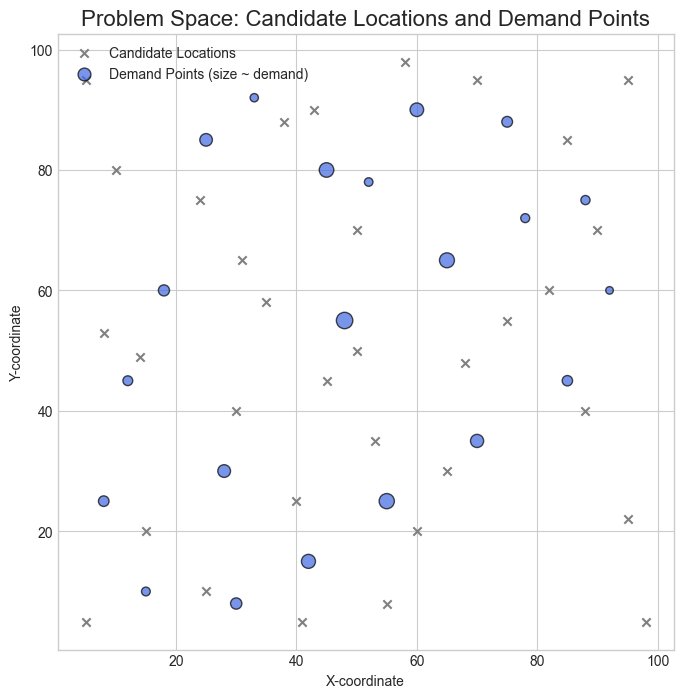

In [3]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

# Plot candidate locations (grey crosses)
ax.scatter(candidate_locations[:, 0], candidate_locations[:, 1], c='gray', marker='x', label='Candidate Locations')

# Plot demand points (blue circles, size proportional to demand)
demand_plot = ax.scatter(demand_points[:, 0], demand_points[:, 1], 
                         s=demand_points[:, 2] / 50,  # Scale demand for better visibility
                         c='royalblue', alpha=0.7, edgecolors='k',
                         label='Demand Points (size ~ demand)')

ax.set_title('Problem Space: Candidate Locations and Demand Points', fontsize=16)
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.legend()
ax.set_aspect('equal', adjustable='box')
plt.show()

## Section 3: Model Configuration

Here, we define all the parameters for both the `CostCalculator` and the `CLIMFO` optimizer. These values are based on the paper's context and can be tuned.

In [4]:
# --- Cost Function Parameters (based on paper's context, some values are illustrative) ---
cost_parameters = {
    # f1: Investment Costs
    "construction_cost_evbss": 200000, # Cost per station
    "construction_cost_ccsb": 1000000, # One-time cost for the central station
    "operational_cost_per_station": 50000, # Annual staff, maintenance, etc.
    "lifetime": 10, # years, for annualization

    # f2: User Time Costs
    "avg_speed": 40, # km/h
    "user_time_cost_per_hour": 15, # $ per hour

    # f3: Swapping & Queueing Costs
    "bsm_per_station": 2, # Battery Swapping Machines (servers) per station
    "avg_service_time_mins": 5, # Average time to perform a swap
}

# --- CLIMFO Algorithm Parameters ---
climfo_parameters = {
    "N_moths": 50,
    "Max_Iter": 100, # Reduced for faster notebook execution; paper used 200
    "D": 5, # The number of stations we want to find
    "lower_bound": 0,
    "upper_bound": len(candidate_locations) - 1
}

# Instantiate the Cost Calculator
cost_calculator = CostCalculator(cost_params=cost_parameters)

print("Models configured successfully.")

Models configured successfully.


## Section 4: Running the Optimization

With all components in place, we now instantiate and run the CLIMFO optimizer. The algorithm will search the solution space for the combination of 5 stations that minimizes the total annual cost calculated by our cost function.

In [5]:
# Instantiate the optimizer
optimizer = CLIMFO(
    N_moths=climfo_parameters['N_moths'],
    Max_Iter=climfo_parameters['Max_Iter'],
    D=climfo_parameters['D'],
    lower_bound=climfo_parameters['lower_bound'],
    upper_bound=climfo_parameters['upper_bound']
)

# Run the optimization process
best_solution_indices, best_cost, cost_history = optimizer.optimize(
    cost_function=cost_calculator,
    candidate_locations=candidate_locations,
    demand_points=demand_points
)

print("\n--- Optimization Finished ---")
print(f"Optimal Station Indices: {best_solution_indices}")
print(f"Minimum Annual Cost: ${best_cost:,.2f}")

Iteration 1/100...
Iteration 2/100...
Iteration 3/100...
Iteration 4/100...
Iteration 5/100...
Iteration 6/100...
Iteration 7/100...
Iteration 8/100...
Iteration 9/100...
Iteration 10/100...
Iteration 11/100...
Iteration 12/100...
Iteration 13/100...
Iteration 14/100...
Iteration 15/100...
Iteration 16/100...
Iteration 17/100...
Iteration 18/100...
Iteration 19/100...
Iteration 20/100...
Iteration 21/100...
Iteration 22/100...
Iteration 23/100...
Iteration 24/100...
Iteration 25/100...
Iteration 26/100...
Iteration 27/100...
Iteration 28/100...
Iteration 29/100...
Iteration 30/100...
Iteration 31/100...
Iteration 32/100...
Iteration 33/100...
Iteration 34/100...
Iteration 35/100...
Iteration 36/100...
Iteration 37/100...
Iteration 38/100...
Iteration 39/100...
Iteration 40/100...
Iteration 41/100...
Iteration 42/100...
Iteration 43/100...
Iteration 44/100...
Iteration 45/100...
Iteration 46/100...
Iteration 47/100...
Iteration 48/100...
Iteration 49/100...
Iteration 50/100...
Iteration

## Section 5: Results and Visualization

Finally, let's visualize the output. We will plot the convergence of the algorithm and the final optimal placement of the stations on the map, including their Voronoi service areas.

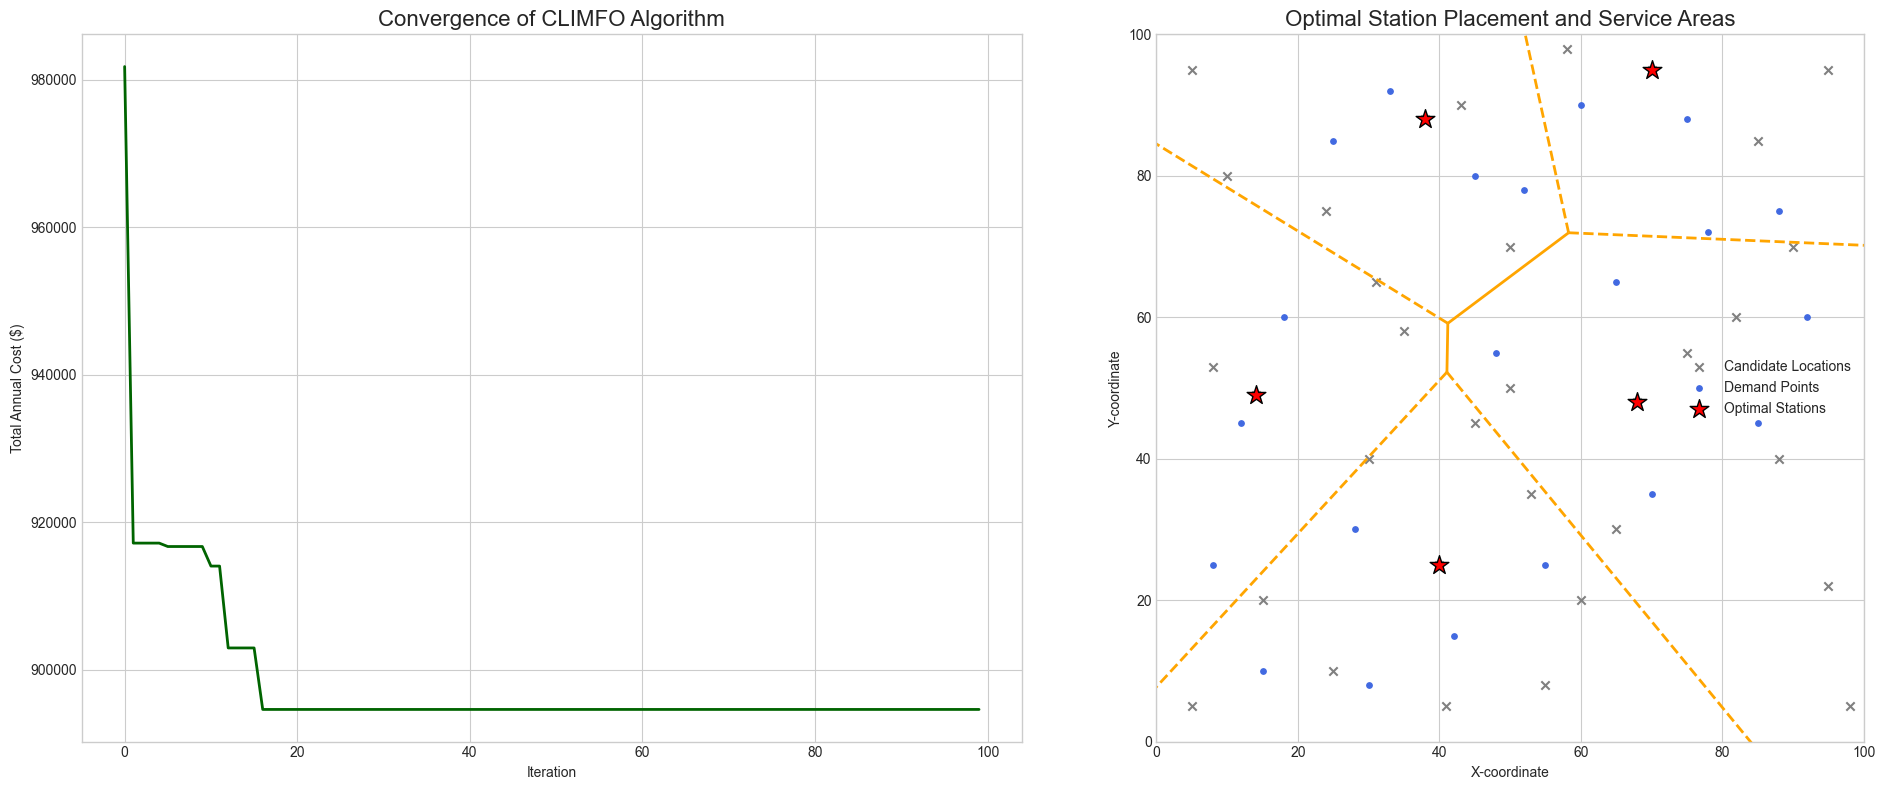

In [6]:
# Plot 1: Convergence Curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

ax1.plot(cost_history, color='darkgreen', linewidth=2)
ax1.set_title('Convergence of CLIMFO Algorithm', fontsize=16)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Total Annual Cost ($)')
ax1.grid(True)

# Plot 2: Optimal Locations and Voronoi Regions
optimal_station_coords = candidate_locations[best_solution_indices]

# Plot all candidate and demand points
ax2.scatter(candidate_locations[:, 0], candidate_locations[:, 1], c='gray', marker='x', label='Candidate Locations')
ax2.scatter(demand_points[:, 0], demand_points[:, 1], s=15, c='royalblue', label='Demand Points')

# Plot the optimal station locations
ax2.scatter(optimal_station_coords[:, 0], optimal_station_coords[:, 1], 
            s=200, c='red', marker='*', edgecolors='k', zorder=5, label='Optimal Stations')

# Create and plot the Voronoi diagram
vor = Voronoi(optimal_station_coords)
voronoi_plot_2d(vor, ax=ax2, show_vertices=False, line_colors='orange', line_width=2, point_size=0)

ax2.set_title('Optimal Station Placement and Service Areas', fontsize=16)
ax2.set_xlabel('X-coordinate')
ax2.set_ylabel('Y-coordinate')
ax2.legend()
ax2.set_aspect('equal', adjustable='box')
ax2.set_xlim([0, 100])
ax2.set_ylim([0, 100])

plt.tight_layout()
plt.show()

---
## Phase 3: Sensitivity Analysis for Optimal Number of Stations (D)

In Phase 2, we found the optimal placement for a *fixed* number of 5 stations. But is 5 truly the best number?

* **Too few stations:** Leads to long travel times for users and high congestion (long queues), increasing `f2` and `f3` costs.
* **Too many stations:** Leads to excessive construction and operational costs, increasing the `f1` cost.

The goal of this phase is to find the "sweet spot". We will run the entire CLIMFO optimization for a range of `D` values (from 2 to 10 stations) and plot the resulting minimum cost for each case. The lowest point on this curve will reveal the most cost-effective number of stations for our scenario.

In [7]:
# --- Sensitivity Analysis Configuration ---
d_range = range(2, 11) # Test for 2 through 10 stations
results = []
best_costs_per_d = {}

print("--- Starting Sensitivity Analysis ---")

for d_value in d_range:
    print(f"\n--- Optimizing for D = {d_value} stations ---")
    
    # Configure optimizer for the current D value
    optimizer = CLIMFO(
        N_moths=climfo_parameters['N_moths'],
        Max_Iter=climfo_parameters['Max_Iter'],
        D=d_value,
        lower_bound=climfo_parameters['lower_bound'],
        upper_bound=climfo_parameters['upper_bound']
    )
    
    # Run the optimization
    best_solution, best_cost, _ = optimizer.optimize(
        cost_function=cost_calculator,
        candidate_locations=candidate_locations,
        demand_points=demand_points
    )
    
    # Store the results
    best_costs_per_d[d_value] = best_cost
    print(f"Result for D={d_value}: Minimum Cost = ${best_cost:,.2f}")

print("\n--- Sensitivity Analysis Finished ---")

--- Starting Sensitivity Analysis ---

--- Optimizing for D = 2 stations ---
Iteration 1/100...
Iteration 2/100...
Iteration 3/100...
Iteration 4/100...
Iteration 5/100...
Iteration 6/100...
Iteration 7/100...
Iteration 8/100...
Iteration 9/100...
Iteration 10/100...
Iteration 11/100...
Iteration 12/100...
Iteration 13/100...
Iteration 14/100...
Iteration 15/100...
Iteration 16/100...
Iteration 17/100...
Iteration 18/100...
Iteration 19/100...
Iteration 20/100...
Iteration 21/100...
Iteration 22/100...
Iteration 23/100...
Iteration 24/100...
Iteration 25/100...
Iteration 26/100...
Iteration 27/100...
Iteration 28/100...
Iteration 29/100...
Iteration 30/100...
Iteration 31/100...
Iteration 32/100...
Iteration 33/100...
Iteration 34/100...
Iteration 35/100...
Iteration 36/100...
Iteration 37/100...
Iteration 38/100...
Iteration 39/100...
Iteration 40/100...
Iteration 41/100...
Iteration 42/100...
Iteration 43/100...
Iteration 44/100...
Iteration 45/100...
Iteration 46/100...
Iteration 47

### Visualize the Final Cost Curve

Now, we plot the key result of our entire study. The x-axis shows the number of stations deployed, and the y-axis shows the lowest possible annual cost for that deployment. The minimum point of this U-shaped curve is our final answer.

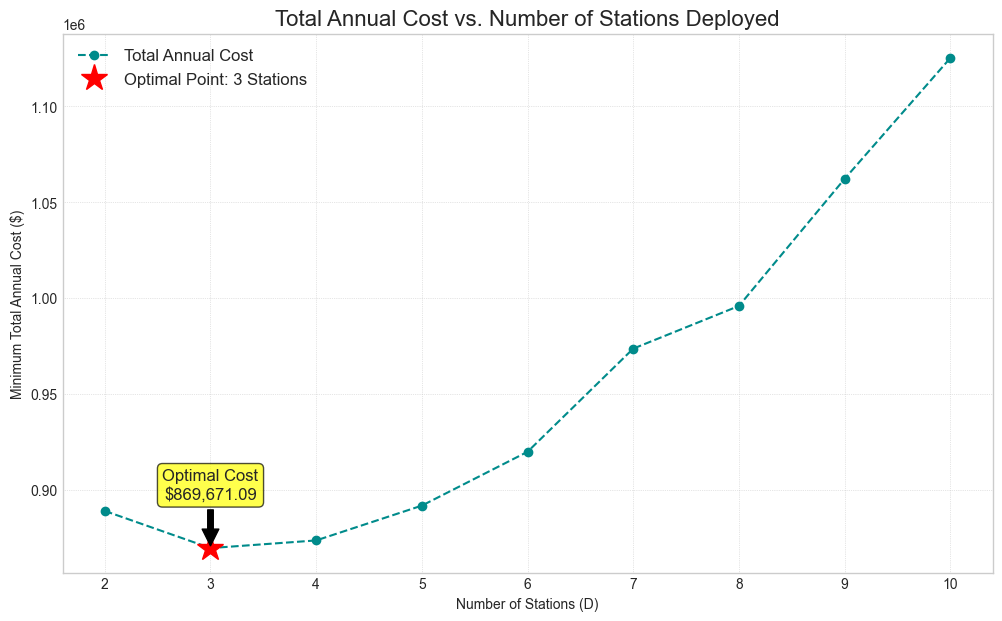

In [8]:
# Extract the results for plotting
d_values = list(best_costs_per_d.keys())
costs = list(best_costs_per_d.values())

# Find the optimal point
optimal_d = min(best_costs_per_d, key=best_costs_per_d.get)
optimal_cost = best_costs_per_d[optimal_d]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(d_values, costs, marker='o', linestyle='--', color='darkcyan', label='Total Annual Cost')
ax.plot(optimal_d, optimal_cost, marker='*', markersize=20, color='red', linestyle='none', 
        label=f'Optimal Point: {optimal_d} Stations')

ax.set_title('Total Annual Cost vs. Number of Stations Deployed', fontsize=16)
ax.set_xlabel('Number of Stations (D)')
ax.set_ylabel('Minimum Total Annual Cost ($)')
ax.set_xticks(d_values)
ax.grid(True, which='both', linestyle=':', linewidth=0.5)
ax.legend(fontsize=12)

# Annotate the optimal point
ax.annotate(
    f'Optimal Cost\n${optimal_cost:,.2f}',
    xy=(optimal_d, optimal_cost),
    xytext=(optimal_d, optimal_cost + (max(costs) - min(costs)) * 0.1), # Offset text
    arrowprops=dict(facecolor='black', shrink=0.05),
    horizontalalignment='center',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1, alpha=0.7)
)

plt.show()